In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

from sklearn.preprocessing import PolynomialFeatures


sns.set_theme(style='whitegrid', font='Franklin Gothic Book')
WIDE = (5*1.618, 5)
SQUARE = (5, 5)

In [3]:
data = pd.read_csv('data/2024_07/all_time_men_all_events.csv')

In [9]:
def convert_to_meters(row: str) -> int:
    try:
        distance = int(row.replace('m', ''))
    except:
        match row:
            case 'mile': distance = 1609
            case '2mile': distance = 3218
            case 'halfMarathon': distance = 21097
            case 'marathon': distance = 42195

    return distance

In [ ]:
data['distance_meters'] = data['event'].apply(convert_to_meters)
# data['distance_meters'].unique()

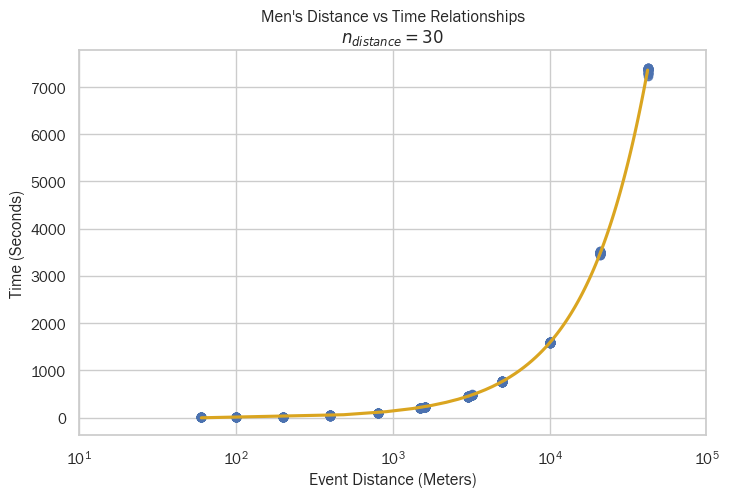

In [61]:
plot_data = data.sort_values(['distance_meters', 'Mark_Seconds']).groupby('event').head(30)

plt.figure(figsize=WIDE)
# plt.scatter(plot_data['distance_meters'], plot_data['Mark_Seconds'])
sns.regplot(data=plot_data,
            x='distance_meters',
            y='Mark_Seconds',
            # lowess=True,
            order=3,
            line_kws={'color': 'goldenrod'})
plt.xscale('log')
plt.xticks(np.geomspace(10, 100000, 5, endpoint=True))
plt.title("Men's Distance vs Time Relationships\n$n_{distance} = 30$")
plt.ylabel('Time (Seconds)')
plt.xlabel('Event Distance (Meters)')

plt.show()

### Power Law, according to Riegel (1981)

In [111]:
def plot_power_law(data):
    data['log_x'] = np.log(data['distance_meters'])
    data['log_y'] = np.log(data['Mark_Seconds'])
    
    plt.figure(figsize=SQUARE)
    sns.regplot(data=data,
                x='log_x',
                y='log_y')
    plt.show()

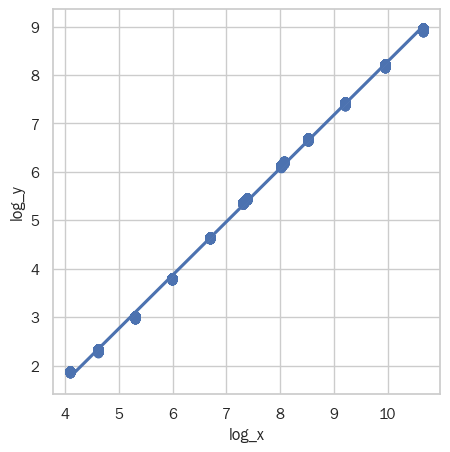

In [112]:
plot_power_law(data=data)

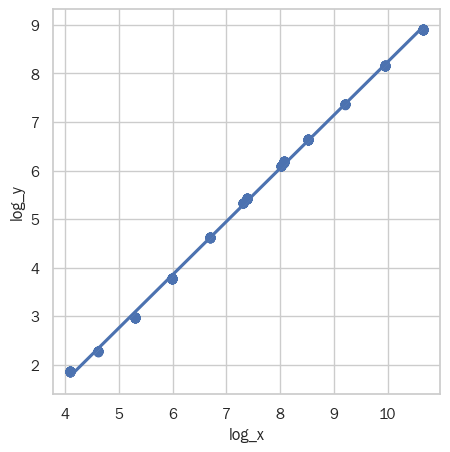

In [113]:
plot_power_law(data=plot_data)

In [84]:
X = sm.add_constant(np.log(plot_data['distance_meters']))
Y = np.log(plot_data['Mark_Seconds'])

mens_rlm = sm.RLM(Y, X, M=sm.robust.norms.HuberT()).fit()
mens_rlm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           Mark_Seconds   No. Observations:                  390
Model:                            RLM   Df Residuals:                      388
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 20 Jul 2024                                         
Time:                        12:10:55                                         
No. Iterations:                    23                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.7100      0.012   -228.087      0.000      -2.733      -2.687
distance_meters     1.0948      0.002    701.729      0.000       1.092       1.098
===================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [85]:
mens_lm = sm.OLS(Y, X).fit()
mens_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Mark_Seconds   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.208e+05
Date:                Sat, 20 Jul 2024   Prob (F-statistic):               0.00
Time:                        12:11:07   Log-Likelihood:                 560.07
No. Observations:                 390   AIC:                            -1116.
Df Residuals:                     388   BIC:                            -1108.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.7228      0.012   -235.372      0.000      -2.746      -2.700
distance_meters     1.0962      0.002    721.644      0.000       1.093       1.099
==============================================================================
Omnibus:                       32.766   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.821
Skew:                          -0.386   Prob(JB):                     8.19e-05
Kurtosis:                       2.251   Cond. No.                         30.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Quadratic Model

In [88]:
X = PolynomialFeatures(degree=2).fit_transform(plot_data[['distance_meters']])
Y = plot_data['Mark_Seconds']

sm.OLS(Y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Mark_Seconds   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.808e+06
Date:                Sat, 20 Jul 2024   Prob (F-statistic):               0.00
Time:                        12:12:28   Log-Likelihood:                -1653.8
No. Observations:                 390   AIC:                             3314.
Df Residuals:                     387   BIC:                             3326.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.7910      1.150    -17.216      0.000     -22.051     -17.531
x1             0.1569      0.000    575.515      0.000       0.156       0.157
x2          4.279e-07   6.67e-09     64.126      0.000    4.15e-07    4.41e-07
==============================================================================
Omnibus:                      191.326   Durbin-Watson:                   0.300
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2498.670
Skew:                          -1.731   Prob(JB):                         0.00
Kurtosis:                      14.907   Cond. No.                     6.86e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.86e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
X = PolynomialFeatures(degree=3).fit_transform(plot_data[['distance_meters']])
Y = plot_data['Mark_Seconds']

sm.OLS(Y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Mark_Seconds   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.195e+06
Date:                Sat, 20 Jul 2024   Prob (F-statistic):               0.00
Time:                        12:12:56   Log-Likelihood:                -1622.3
No. Observations:                 390   AIC:                             3253.
Df Residuals:                     386   BIC:                             3268.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.2193      1.259    -11.293      0.000     -16.695     -11.744
x1             0.1522      0.001    244.583      0.000       0.151       0.153
x2          8.034e-07    4.6e-08     17.450      0.000    7.13e-07    8.94e-07
x3          -6.38e-12   7.75e-13     -8.231      0.000    -7.9e-12   -4.86e-12
==============================================================================
Omnibus:                      245.226   Durbin-Watson:                   0.321
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4360.234
Skew:                          -2.315   Prob(JB):                         0.00
Kurtosis:                      18.712   Cond. No.                     3.35e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.35e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""